<h1 style='font-size:40px'> Classification</h1>
<h2 style='font-size:30px'> Apresentação do dataset</h2>
<div>
    <ul style='font-size:20px'>
        <li>
            Neste capítulo, lidaremos com dataset MNIST, que contém 70 mil imagens de algarismos escritos à mão por estudantes do Ensino Médio americano e empregados do escritório de censos dos EUA.
        </li>
    </ul>
</div>

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)

In [2]:
# Extraindo os dados de treino e teste. Cada coluna de 'X' é a intensidade do pixel da foto do dígito. 
# Como as imagens são 28x28, temos um total de 784 pixels e colunas.
X = mnist.data
y = mnist.target.astype(int)

<h3 style='font-size:30px;font-style:italic'> Conhecendo os dados</h3>

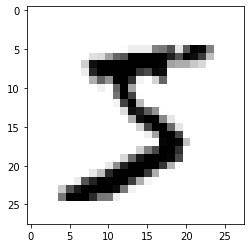

In [3]:
# Vamos analisar a imagem de um dos dígitos do dataset utilizando o matplotlib.
import matplotlib.pyplot as plt
from matplotlib.cm import binary
import numpy as np

# Obtendo os pixels do primeiro número do dataset.
some_digit_image = X.iloc[0].values.reshape(28,28)

# Tudo indica que se trata de um cinco.
plt.imshow(some_digit_image, cmap=binary, interpolation='nearest')

In [4]:
# E, de fato, o dígito em questão é um 5.
y[0]

5

<h3 style='font-size:30px;font-style:italic'> Segregação de dados</h3>
<div>
    <ul style='font-size:20px'>
        <li>
            Os dados de <em>mnist</em> já estão ordenados de maneira que as 60 mil primeiras ocorrências sejam destinadas a treino e as outras 10 mil instâncias para teste.
        </li>
    </ul>
</div>

In [5]:
# Um unpacking de tuplas será o suficiente para essa operação.
X_train, X_test, y_train, y_test = X.iloc[:60000], X.iloc[60000:], y.iloc[:60000], y.iloc[60000:]

<h2 style='font-size:30px'> Training a Binary Classifier</h2>
<div>
    <ul style='font-size:20px'>
        <li>
            Vamos começar o capítulo com uma tarefa simples: criar um classificador que identifique quando a imagem se refere a um número definido x, e quando ela não representa X. Neste caso, estamos diante de um trabalho de classificação binária.
        </li>
    </ul>
</div>

In [6]:
# O autor escolheu identificar as ocorrências de 5 e não-5.

# Os novos datasets terão valores booleanos. True para 5 e False para não-5
y_train_5 = y_train == 5
y_test_5 = y_test == 5

<div>
    <ul style='font-size:20px'>
        <li>
            Para começar a nossa tarefa, vamos utilizar o Stochastic Gradient Descent (SGD), do módulo sklearn.linear_model. Ele é bastante eficaz em lidar com datasets grandes.
        </li>
    </ul>
</div>

In [7]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

# Prevendo o valor da primeira instância de X (5). O classificador adivinha com sucesso.
sgd_clf.predict(X.iloc[0].values.reshape(1,-1))

/home/veiga/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

<h2 style='font-size:30px'> Performance Measures</h2>
<div>
    <ul style='font-size:20px'>
        <li>
            Aqui, o autor faz uma breve demosntração sobre como a acurácia pode não ser a métrica de qualidade mais adequada com datasets desbalanceados.
        </li>
    </ul>
</div>

In [8]:
# Realizando uma validação cruzada cuja métrica de performance é o score do modelo. 
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5,cv=3, scoring='accuracy').mean()

0.9570333333333334

In [9]:
# Agora, vamos criar um Dummy Classifier caseiro com a classe pré-definida BaseEstimator.
# Ele sempre previrá que o número não é 5.
from sklearn.base import BaseEstimator
import numpy as np
class Never5Classifier(BaseEstimator):
    # Algo que eu havia esquecido sobre POO, podemos fazer uma classe sem um __init__.
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        return np.zeros((len(X),1), dtype='bool' )


In [10]:
# Agora, vamos fazer uma validação cruzada com esse classificador 'burro'
never_5_clf = Never5Classifier()

# Veja, mesmo sendo dogmático, Never5Classifier tem uma taxa de acerto de quase 91%.
cross_val_score(never_5_clf, X_train, y_train_5, cv=3 ,scoring='accuracy').mean()

0.90965

<h3 style='font-size:30px;font-style:italic'> Confusion Matrix</h3>
<div>
    <ul style='font-size:20px'>
        <li>
            A matriz de confusão é uma represetação visual que contabiliza o número de classificações (certas ou erradas) feitas pelo modelo. Como apontado pelo autor, se quiséssemos saber quantas vezes o algoritmo confundiu 5 com 3, basta olharmos a terceira coluna da quinta linha da matriz. 
        </li>
    </ul>
</div>

In [11]:
# Prevendo os valores-alvo do dataset de treino com cross_val_predict
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf,X_train, y_train_5, cv=3)

In [12]:
# As linhas representam a classe verdadeira; já as colunas, a classe prevista pelo modelo.

# Nesse caso, temos mais de 50 mil valores não-5 previstos como não-5 e 3530 5's rotulados como 5.
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

<AxesSubplot:>

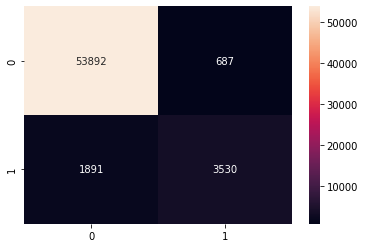

In [13]:
# Podemos utilizar um mapa de calor do seaborn para melhorar a visualização dos dados.
import seaborn as sns
sns.heatmap(confusion_matrix(y_train_5, y_train_pred), annot=True, fmt='.5g')

<div>
    <ul style='font-size:20px'>
        <li>
            A partir da matriz de confusão, podemos estimar novas métricas qualitativas sobre o modelo. Por exemplo, entre as instâncias classificadas como positivas (1), qual a porcentagem delas é realmente positiva (Precision)? Ou, de todas as instâncias positivas do dataset, qual a porcentagem delas foi que o modelo conseguiu rotular como tal (Recall)? 
        </li>
    </ul>
</div>
<center> 
    <img src='precision_recall1.png'>
</center>

<h3 style='font-size:30px;font-style:italic'> Precision and Recall</h3>

In [14]:
# Medindo as novas métricas aprendidas com o sklearn.metrics
from sklearn.metrics import recall_score, precision_score
print(f'Precisão do modelo: {precision_score(y_train_5,y_train_pred) :.2%}')
print(f'Recall do modelo: {recall_score(y_train_5,y_train_pred) :.2%}')

Precisão do modelo: 83.71%
Recall do modelo: 65.12%


<h3 style='font-size:30px;font-style:italic'> F1-Score</h3>
<div>
    <ul style='font-size:20px'>
        <li>
            O F1-Score é a média harmônica entre precision e recall. Diferentemente de uma média comum, esse índice dá um peso maior a valores pequenos.
        </li>
    </ul>
</div>

In [15]:
from sklearn.metrics import f1_score
print(f'F1-Score do modelo: {f1_score(y_train_5,y_train_pred) :.2%}')

F1-Score do modelo: 73.25%


<h3 style='font-size:30px;font-style:italic'> Precision/Recall Tradeoff</h3>
<div>
    <ul style='font-size:20px'>
        <li>
            Neste tópico, o autor discorre sobre a inevitável correlação negativa entre precision e recall. Quando queremos aumentar o valor de um dos índices, teremos que sacrificar parte do desempenho do outro.
        </li>
        <li>
            Para ilustrar como isso ocorre, é apresentada a função de pontuação da chamada <em>decision_function</em>. Os modelos de classificação aplicam essa função para cada instância a ser rotulada, o que se resulta em um número. Esse valor pode ser maior ou menor do que o threshold escolhido. Caso seja mais alto, a instância será agrupada na classe positiva; caso o contrário, na classe negativa.  
        </li>
        <li>
            O scikit-learn não nos permite ajustar esse threshold ao criarmos o modelo, mas podemos ajustá-lo, manualmente, com uma simples expressão comparativa. 
        </li>
    </ul>
</div>

In [16]:
# Ao invés de invocarmos 'predict', chamaremos o método 'decision_function' ao SGDClassifier.
# Qual é o valor da função de decisão na nossa instância 'some_digit_image'?
y_scores = sgd_clf.decision_function(some_digit_image.reshape(1,-1))
y_scores

/home/veiga/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([2164.22030239])

In [17]:
# Definindo o threshold como 0, como o classificador rotulará a instância?
thresold = 0
y_some_digit_pred = y_scores > thresold
y_some_digit_pred

array([ True])

In [18]:
# Agora, o thresolhd será elevado a 8000. Como sera a previsão?
thresold = 8000
y_some_digit_pred = y_scores > thresold
y_some_digit_pred

array([False])

<div> 
    <ul style='font-size:20px'> 
        <li>
            Isso constata que, aumentar o thresolhd diminui o recall do modelo.
        </li>
    </ul>
</div>

In [19]:
# O 'cross_val_predict' é capaz de nos retornar a pontuação da decision function do modelo.
# Basta definirmos  'method' como 'decision_function'.

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [20]:
# O scikit-learn tem um método capaz de nos mostrar as variações de precision de acordo com o thresolhd visualmente.
from sklearn.metrics import precision_recall_curve

# A função nos retorna os índices e seus respectivos thresholds.
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

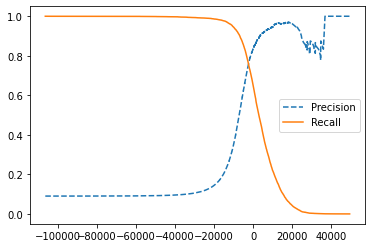

In [21]:
import matplotlib.pyplot as plt
# É comum a curva de precision sofrer pequenas quedas enquanto o threshold aumenta.
plt.plot(thresholds, precisions[:-1], linestyle='--', label='Precision')
plt.plot(thresholds, recalls[:-1], linestyle='-', label='Recall')
plt.legend()

Text(0, 0.5, 'Precision')

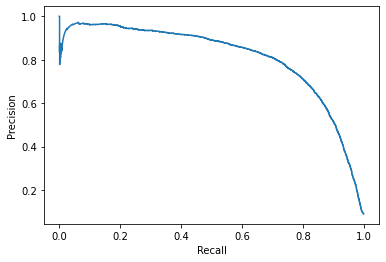

In [22]:
# Outra maneira de se plotar os dados, só que sem os thresholds.
plt.plot(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')

In [23]:
# Supondo que quiséssemos ter no mínimo 90% de precisão. Qual threshold escolher?

# np.argmax retorna o primeiro índice do valor máximo (como a condição passada entre parênteses é booleana,
# o índice será o do primeiro True que aparecer)

# Ok, o primeiro threshold que nos dará mais de 90% de precisão está na posição 57075 de 'thresolhds'.
print(np.argmax(precisions>=0.9))

threshold_90_precision = thresholds[np.argmax(precisions>0.9)]
threshold_90_precision

57075


3370.019499143957

In [24]:
# Agora, fazendo previsões usando o threshold escolhido.
y_train_pred_90 = (y_scores >= threshold_90_precision)
y_train_pred_90

array([False, False, False, ...,  True, False, False])

In [25]:
# Por questões de verificação, calculando a precision e recall dessas previsões.
print(f'Precisão: {precision_score(y_train_5, y_train_pred_90) :.2%}')
print(f'Recall: {recall_score(y_train_5, y_train_pred_90) :.2%}')

Precisão: 90.00%
Recall: 48.00%


<div> 
    <ul style='font-size:20px'> 
        <li>
            O autor nos adverte que, no entanto, não é recomendável priorizarmos precision em  prejuízo a recall. 
        </li>
    </ul>
</div>

<h3 style='font-size:30px;font-style:italic'> The ROC Curve</h3>
<div> 
    <ul style='font-size:20px'> 
        <li>
             A curva ROC mostra a relação entre a taxa de positivos verdadeiros (aka. recall) versus a taxa de falsos positivos.
        </li>
        <li>
            A taxa de falsos positivos pode ser entendida também como 1 - (taxa de negativos verdadeiros (aka. specificity))
        </li>
    </ul>
</div>

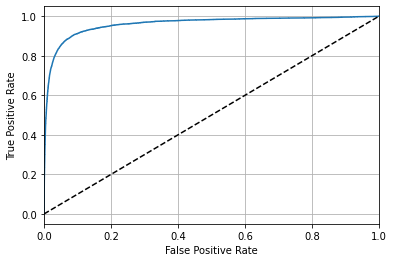

In [26]:
# Novamente, o sklearn.metrics tem uma função pronta para plotagem de ROC Curves.
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], 'k--')
plt.xlim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

<div> 
    <ul style='font-size:20px'> 
        <li>
            A linha tracejada indica as taxas obtidas por um classificador meramente aleatório.
        </li>
        <li>
            O ideal para os classificadores binários é que a área sob a ROC Curve fique o mais próxima o possível de 1.
        </li>
    </ul>
</div>

In [27]:
# Coumputando a area under the curve de nosso modelo.
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

<div> 
    <ul style='font-size:20px'> 
        <li>
            O autor recomenda que a PR Curve seja utilizada apenas com datasets com poucas classes positivas; ou quando nos importamos mais com falsos positivos do que com falsos negativos. Caso o contrário, use ROC Curve.
        </li>
    </ul>
</div>

<h3 style='font-size:30px;font-style:italic'> Teste com o RandomForest</h3>
<div> 
    <ul style='font-size:20px'> 
        <li>
             O autor tentará comparar a ROC Curve e a AUC de uma Random Forest com as já mensuradas. 
        </li>
        <li>
            No entanto, o RandomForestClassifier não tem decision_function imbutida. Ao invés disso, ele nos retorna as probabilidades de classe em um array. Para cada instância, uma linha com as probabilidades de classe aparecem.
        </li>
    </ul>
</div>

In [32]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

# Como já dito, o array retornado nos dá uma coluna para cada classe. No entanto, 'roc_curve' admite um array unidimensional apenas.
y_probas_forest

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

In [33]:
# Considerando isso, vamos selecionar apenas as probabilidades de classe positiva.
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

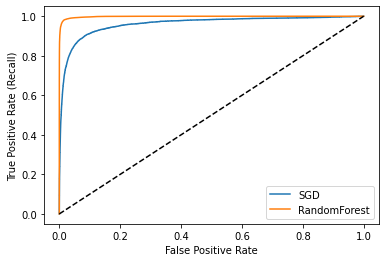

In [44]:
# Com isso, estamos prontos para fazermos a comparação.
plt.plot(fpr, tpr, label='SGD')
plt.plot(fpr_forest, tpr_forest, label='RandomForest')
plt.plot([0,1], [0,1], linestyle='--', color='k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
# Visivelmente, a Random Forest tem um auc_score maior.
plt.legend()

In [43]:
# AUC Scores do modelo.
print(f'AUC Score SGD: {roc_auc_score(y_train_5, y_scores)}')
print(f'AUC Score Random Forest: {roc_auc_score(y_train_5, y_scores_forest)}')

AUC Score SGD: 0.9604938554008616
AUC Score Random Forest: 0.9983436731328145


In [47]:
# A fim de termos uma avaliação completa da Random Forest, vamos calcular sua precision e recall.

# Lembre-se, essa métricas são calculadas com base nas previsões reais do modelo, e não em suas 'decision_function''s ou 'predict_proba''s.
forest_predict = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict')
forest_precision = precision_score(y_train_5, forest_predict)
forest_recall = recall_score(y_train_5, forest_predict)

In [50]:
# A Random Forest novamente bate o SGDClassifier.
print(f'Precisão Random Forest: {forest_precision}')
print(f'Recall Random Forest: {forest_recall}')

Precisão Random Forest: 0.9905083315756169
Recall Random Forest: 0.8662608374838591


<h2 style='font-size:30px'> Multiclass Classification</h2>
<div>
    <ul style='font-size:20px'>
        <li>
            Com relação às multiplas classificações, existem algoritmos capazes de lidar com várias categorias diretamente (como o Naive Bayer ou o próprio Random Forest). Por outro lado, alguns outros são construídos para apenas serem usados em situações de classificação binária (como o SVM e classificadores Lineares).
        </li>
    </ul>
</div>

<h3 style='font-size:30px;font-style:italic'> One versus All</h3>
<div> 
    <ul style='font-size:20px'> 
        <li>
            Apesar disso, ainda conseguimos usar classificadores binários em situações de classificações múltiplas. A estratégia <em>One versus All</em>, em que, para cada categoria, é criado um classificador responsável por identificar dados que são pertencentes ou não a ela (ex: 5's e não-5's; 3's e não-3's). Quando esses modelos confrontarem uma instância nunca vista, aquele com a maior pontuação de decision_function é o que a rotulará. Ou seja, se o classificador de 5's tiver o maior valor, a instância será rotulada como 5.
        </li>
        <li>
            A desvantagem dessa abordagem é que cada classificador será alimentado com uma cópia completa do dataset de treino. Para modelos como o SVM, isso pode gerar fases de treino muito lentas.
        </li>
    </ul>
</div>

<p style='color:red'> Continuar a partr 'But to plot a ROC curve, you need scores (...) ', página 101</p>